<a href="https://colab.research.google.com/github/Treynt/Transfer_Learning/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# # Bloco 1: Carregamento do Dataset Cats vs Dogs
# # ------------------------------------------
# import tensorflow_datasets as tfds

# # Carregar o dataset Cats vs Dogs com TensorFlow Datasets
# (train_data, val_data), dataset_info = tfds.load(
#     'cats_vs_dogs',
#     split=['train[:80%]', 'train[80%:]'],  # 80% treino, 20% validação
#     as_supervised=True,  # Formato (imagem, rótulo)
#     with_info=True       # Retorna informações adicionais do dataset
# )

# print("Dataset carregado com sucesso!")
# print(f"Informações do dataset: {dataset_info}")

# Bloco 1: Carregamento do Dataset Cats vs Dogs com Redução
# ------------------------------------------
import tensorflow_datasets as tfds

# Carregar o dataset Cats vs Dogs com redução de tamanho
(train_data_full, val_data_full), dataset_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],  # 80% treino, 20% validação
    as_supervised=True,  # Formato (imagem, rótulo)
    with_info=True       # Retorna informações adicionais do dataset
)

# Limitar o tamanho do dataset para acelerar o treinamento
train_data = train_data_full.take(5000)  # Apenas 5000 exemplos de treino
val_data = val_data_full.take(1000)      # Apenas 1000 exemplos de validação

print("Dataset reduzido!")
print(f"Tamanho do conjunto de treino: {len(list(train_data))}")
print(f"Tamanho do conjunto de validação: {len(list(val_data))}")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.XJGMCE_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Dataset reduzido!
Tamanho do conjunto de treino: 5000
Tamanho do conjunto de validação: 1000


In [ ]:
# Bloco 2: Pré-processamento do Dataset
# ------------------------------------------

import tensorflow as tf

# Função para redimensionar e normalizar as imagens
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # Redimensiona para 224x224
    image = image / 255.0  # Normaliza os valores para [0, 1]
    return image, label

# Aplicar pré-processamento
train_data = train_data.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
val_data = val_data.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

print("Pré-processamento concluído!")


Pré-processamento concluído!


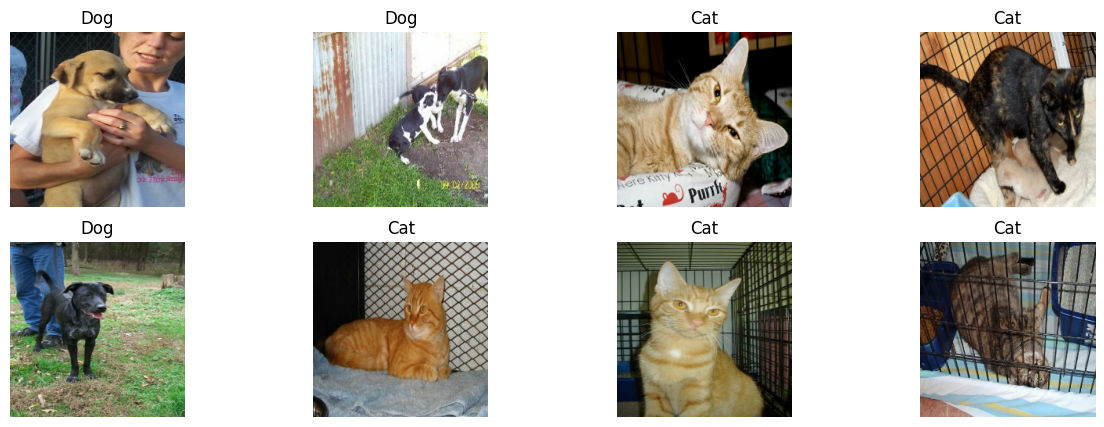

In [ ]:
# # Bloco 3: Visualização de imagens corrigido
# # ------------------------------------------

# import matplotlib.pyplot as plt

# # Função para visualizar imagens
# def plot_images(dataset, class_names, num_images=8):
#     plt.figure(figsize=(15, 5))
#     count = 0
#     for image, label in dataset.unbatch().take(num_images):  # Remove o batch
#         plt.subplot(2, 4, count + 1)
#         plt.imshow(image.numpy())  # Converte para array NumPy
#         plt.title(class_names[label.numpy()])  # Converte o rótulo para string
#         plt.axis('off')
#         count += 1
#     plt.show()

# # Exibir imagens de treino
# class_names = ['Cat', 'Dog']
# plot_images(train_data, class_names)

# Bloco 3: Visualização de imagens com embaralhamento
# ---------------------------------------------------

import matplotlib.pyplot as plt

# Função para visualizar imagens embaralhadas
def plot_images(dataset, class_names, num_images=8):
    plt.figure(figsize=(15, 5))
    count = 0
    for image, label in dataset.shuffle(1000).unbatch().take(num_images):  # Embaralha e remove o batch
        plt.subplot(2, 4, count + 1)
        plt.imshow(image.numpy())  # Converte para array NumPy
        plt.title(class_names[label.numpy()])  # Converte o rótulo para string
        plt.axis('off')
        count += 1
    plt.show()

# Exibir imagens de treino
class_names = ['Cat', 'Dog']
plot_images(train_data, class_names)


In [ ]:
# Bloco 4: Construção do modelo com Transfer Learning
# ------------------------------------------

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Carregar VGG16 pré-treinado
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar as camadas do modelo base
for layer in base_model.layers:
    layer.trainable = False

# Construir o modelo final
model = Sequential([
    base_model,  # Modelo base VGG16
    Flatten(),  # Flatten para transformar a saída
    Dense(128, activation='relu'),  # Camada densa totalmente conectada
    Dropout(0.5),  # Dropout para evitar overfitting
    Dense(1, activation='sigmoid'),  # Saída binária (0: Cat, 1: Dog)
])

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 3,211,521 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# # Bloco 5: Treinar o modelo
# # ------------------------------------------

# history = model.fit(
#     train_data,
#     epochs=10,
#     validation_data=val_data,
# )

# print("Treinamento concluído!")

# Bloco 5: Treinar o modelo com menos épocas
# ------------------------------------------

history = model.fit(
    train_data,
    epochs=3,  # Reduzir para 3 épocas
    validation_data=val_data,
)

print("Treinamento concluído!")


Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 50s 204ms/step - accuracy: 0.7545 - loss: 0.7188 - val_accuracy: 0.9090 - val_loss: 0.2211
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 159ms/step - accuracy: 0.8984 - loss: 0.2460 - val_accuracy: 0.9290 - val_loss: 0.1844
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 151ms/step - accuracy: 0.9219 - loss: 0.1899 - val_accuracy: 0.9240 - val_loss: 0.1929
Treinamento concluído!


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9226 - loss: 0.1950
Validation Loss: 0.1929
Validation Accuracy: 0.9240


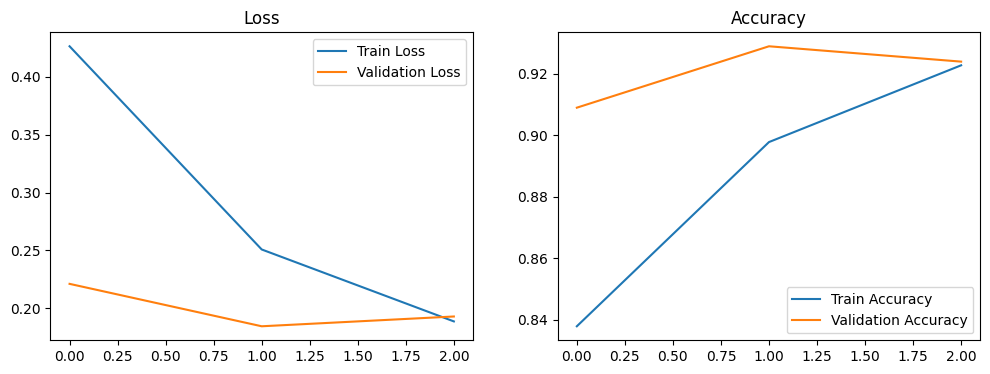

In [ ]:
# Bloco 6: Avaliar e visualizar os resultados
# ------------------------------------------

# Avaliar o modelo no conjunto de validação
loss, accuracy = model.evaluate(val_data)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Plotar Loss e Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.legend()

# Accuracy
ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy')
ax2.legend()

plt.show()
